In [1]:
import sys
# sys.path.insert(0,'C:/Users/annal/OneDrive/Documents/python3.8/pygplates_rev28_python38_win64')
# sys.path.insert(0,'/Users/omer/Documents/pygplates_rev18_python27_MacOS64')
sys.path.insert(0,'/Users/omer/Documents/pygplates_rev28_python38_MacOS64/')
sys.path.insert(1,'/Applications/GMT-6.0.0.app/Contents/Resources')
import pandas as pd

In [2]:
# !pip install pandas
# !pip install scipy

In [3]:
# Below is necessary to import sphere_tools.py 
# !pip install healpy 
# !pip install statsmodels

In [4]:
import pygplates
import numpy as np
import os
import math
import sphere_tools as sph
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels
import sys
from matplotlib.lines import Line2D
from call_system_command import call_system_command
%matplotlib inline

In [5]:
def find_number_of_LIPs(age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    count = 0
    
    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the LIP
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            count+=1
    
    return count

In [6]:
def get_volcanic_product_long_lat(rotations,anchor_plate_id,age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    Xr = []
    Yr = []

    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the Kimberlite
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            PlateID = p.get_reconstruction_plate_id()

            # Get rotation for the point and reconstruct to its birth time if it's in age interval (window)
            Kimb_rotation = rotations.get_rotation(age, PlateID, anchor_plate_id)

            reconstructed_point = Kimb_rotation * p.get_geometry()
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()

            Xr.append(reconstructed_point_degrees.get_longitude())
            Yr.append(reconstructed_point_degrees.get_latitude())
    
    
    return Xr, Yr

In [7]:
# generic function to sample grids using grdtrack and read results
def sample_using_gmt(grdfile, point_lons, point_lats,OutputDirectory):

        dataout = np.vstack((np.asarray(point_lons),np.asarray(point_lats))).T

        np.savetxt(OutputDirectory+'/tmp.txt',dataout)
        
        # Note -nn forces nearest neighbour interpolation
        call_system_command(['gmt',
                             'grdtrack',
                             '%s/tmp.txt' %OutputDirectory,
                             '-G{:s}'.format(grdfile), 
                             '-fg',
                             '-nn',
                             '-V',
                             '>', 
                             '%s/tmp_interp.txt' % OutputDirectory])
        G=[]
        with open(OutputDirectory+'/tmp_interp.txt') as f:
            for line in f:
                if line[0] == '>':
                    continue
                else:
                    tmp = line.split()
                    G.append(float(tmp[2]))

        f.close()
        return np.array(G)

In [8]:
a=float(-0.3)
a

-0.3

In [9]:

def create_hot_nc_file(GridDirect,OutputDirect,TomogModelName,percentContourValue,Ma):
    
    StringFormContour=str(percentContourValue)
    GridFile="%s/%s.nc" %(GridDirect,TomogModelName)
    MaString=str(Ma)
    ContourFile="%s/%s_Contour_%s.txt" %(OutputDirect,TomogModelName,StringFormContour)
    TempGrid1="%s/%s_TempGrid1_%s.nc" %(OutputDirect,TomogModelName,StringFormContour)
    TempGrid2="%s/%s_TempGrid2_%s.nc" %(OutputDirect,TomogModelName,StringFormContour)
    hot_xyz_file="%s/%s_hot_%s_AreaVaried.xyz" %(OutputDirect,TomogModelName,MaString)
    
    DistanceFROMHot="%s/%s_Distance_to_Hot_%s_AreaVaried.nc" %(OutputDirect,TomogModelName,MaString)
    
    
    percentContourValueLow=percentContourValue-0.001
    percentContourValueHigh=percentContourValue+0.001
    
    print(str(percentContourValueLow),str(percentContourValueHigh))
    call_system_command(['gmt',
                     'grdcontour',
                     GridFile,
                     '-D%s' % ContourFile,
                     '-C1',
                     '-L/%s/%s' % (str(percentContourValueLow),str(percentContourValueHigh))])
#     '-L/-0.303/-0.297'])    
    call_system_command(['gmt',
                      'grdclip',
                     GridFile,
                     '-Rd',
                     '-Sa%.1f/1' % percentContourValue,
                     '-G%s' % TempGrid1])
    
    call_system_command(['gmt',
                      'grdclip',
                     TempGrid1,
                     '-Rd',
                     '-Sb1/0',
                     '-G%s' % TempGrid2])
    
    
    call_system_command(['gmt',
                         'grd2xyz',
                         TempGrid2,
                         '-Rd',
                         '-di1',  # set all cells with '1' to be nodata
                         '-s',
                         '>',
                         '%s' % hot_xyz_file])

    call_system_command(['gmt',
                         'grdmath',
                         TempGrid2,
                         '%s' % hot_xyz_file,
                         'PDIST',
                         'KM2DEG',
                         '=',
                         '%s' % DistanceFROMHot])

## Import array of contour values and corresponding area coverage values for different tomographic models

In [10]:
AreasForSavani = pd.read_csv("/Users/omer/Desktop/NatGeoReviews/AreasForSavani.csv",header=None,
                             names=["AreasForSavani"])
ContoursForSavani= pd.read_csv("/Users/omer/Desktop/NatGeoReviews/Contours_Variable.csv",header=None,
                             names=["ContoursVariable"])     
ContoursForSavani

,ContoursVariable
0,-1.50
1,-1.49
2,-1.48
3,-1.47
4,-1.46
...,...
195,0.45
196,0.46
197,0.47
198,0.48


In [11]:
Case1Areas=np.asarray([47.9726287635,42.4100552434,43.2824677183,45.6569380355,46.9831730172,
                      45.5868344616,45.7716162117,41.5415651999,39.9509147286])

TimesForCase1Areas=np.asarray([200,180,160,140,120,100,80,60,40])


In [12]:
AreasForSavaniNP=AreasForSavani.to_numpy()
ContoursForSavaniNP=ContoursForSavani.to_numpy()

In [13]:
GridDirect="/Users/omer/Desktop/NatGeoReviews/Tomographic-Models/Savani/"
OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km/"
TomogModel="Savani_2818"

for index in np.linspace(0,8,9,dtype=int):
    print(index)
    print(index, TimesForCase1Areas[index], " Ma")
  
    myindex=min(range(len(AreasForSavaniNP)), key=lambda i: abs(AreasForSavaniNP[i]-[Case1Areas[index]/100.]))
    ContourToUse=ContoursForSavaniNP[myindex]
    print(float(ContourToUse))
    ContourToUse=float(ContourToUse)
#     "%s%s.nc" %(GridDirect,TomogModel)
#     create_hot_nc_file(GridDirect,OutputDirect,TomogModel,ContourToUse,TimesForCase1Areas[index])

0
0 200  Ma
0.0500000000000013
1
1 180  Ma
-0.0799999999999987
2
2 160  Ma
-0.0599999999999987
3
3 140  Ma
1.3322676295501878e-15
4
4 120  Ma
0.0300000000000013
5
5 100  Ma
1.3322676295501878e-15
6
6 80  Ma
1.3322676295501878e-15
7
7 60  Ma
-0.0999999999999987
8
8 40  Ma
-0.1399999999999988


In [14]:
# DistanceFROMHot

In [15]:
def run_random_sampling(nPoints,age,dist_to_hot_nc_file,CalcOutputDir):
    
#     recon_label = '2017NNR'

#     basedir='/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/M21NNR/NNR/NNR_InFiles/'
#     input_rotation_filename1 = '%s/1000-410_rotations-NNR.rot' % basedir
#     input_rotation_filename2 = '%s/Global_EB_410-250Ma_GK07_2017-NNR.rot' % basedir
#     input_rotation_filename3 = '%s/Global_EB_250-0Ma_GK07_2017-NNR.rot' % basedir
#     input_rotation_filename4 = '%s/NR_0Ma_1000Ma_for_gplates.rot' % basedir
#     rotation_model = pygplates.RotationModel([input_rotation_filename1,input_rotation_filename2,\
#                                               input_rotation_filename3,input_rotation_filename4])

#     ANCHOR_ID = int(0)
#     cratonFileDir='/Users/omer/Documents/Programming/PyGplates/Supplement/Reconstructions/M21NNR/'
#     cratonFile=cratonFileDir+"shapes_cratons_Merdith_et_al.gpml"
    
#     cratonFileDir='/Users/omer/Documents/Programming/PyGplates/Supplement/Reconstructions/NewCratonsForAnalysis/'
#     cratonFile=cratonFileDir+"cratons_150km_thick_with_plate_IDs_manually_edited.gpml"
    age=int(age)
    recon_label = 'M21'
    ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21/'
    cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
    cratons = pygplates.FeatureCollection(cratonFile)    

    input_rotation_filename = '%s/1000_0_rotfile_Merdith_et_al.rot' % ReconstructionDir
    ANCHOR_ID = int(0)
    
    rotation_model=pygplates.RotationModel(input_rotation_filename)

    randomLons = []
    randomLats = []
    random_pdist2hot = []
   
    
    # Start with an empty list of features
    features_to_modify = []
    new_features=[]
    reconstructed_feature_geometries=[]
    
    # Reconstruct cratonic shapes at Age Ma
    pygplates.reconstruct(cratons, rotation_model, reconstructed_feature_geometries, age)
    
#     print(reconstructed_feature_geometries)
#     print(age)
    
    RandomPoints_Lats=np.array([])
    RandomPoints_Lons=np.array([])
    
    totalRandomInsideCratons=0
    
    while(totalRandomInsideCratons<nPoints):
        random_point = sph.random_points_feature(1)
        for mp in random_point:
            for point in mp.get_geometry().get_points():
                pointInDegrees=point.to_lat_lon_point()
                PointLat=pointInDegrees.get_latitude()
                PointLon=pointInDegrees.get_longitude()
                
#                 for static_polygon in cratons:
                for static_polygon in reconstructed_feature_geometries:
#                     PlateID = static_polygon.get_reconstruction_plate_id()
#                     static_polygon_geom = static_polygon.get_geometry()
                    static_polygon_geom = static_polygon.get_reconstructed_geometry()
                    if static_polygon_geom != None:
                        if static_polygon_geom.is_point_in_polygon((PointLat,PointLon)):        
#                             print("inside")
                            RandomPoints_Lats=np.append(RandomPoints_Lats,PointLat)
                            RandomPoints_Lons=np.append(RandomPoints_Lons,PointLon)
                            totalRandomInsideCratons=totalRandomInsideCratons+1
                            cF=pygplates.Feature()
                            cF.set_geometry(point)
                            new_features.append(cF)
    output_feature_collection = pygplates.FeatureCollection(new_features)
    output_feature_collection.write("Random_"+str(nPoints)+"_Points_onCratons_ForSavani_"+str(age)+"_Ma.gpml")

    # for the point locations of interest, sample the distance grids
    # (and the original cluster boolean grid as a sanity check)
    random_pdist2hot = sample_using_gmt(dist_to_hot_nc_file, RandomPoints_Lons, RandomPoints_Lats,CalcOutputDir)
#     random_cluster_bool = sample_using_gmt(cluster_nc_file, RandomPoints_Lons, RandomPoints_Lats)
    
    return random_pdist2hot

In [16]:
# reconstructed_feature_geometries=[]
# pygplates.reconstruct(cratons, rotation_model, reconstructed_feature_geometries, age)

In [17]:
# reconstructed_feature_geometries

200 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_200_AreaVaried.nc
1.8975333665563159 is the mean of the sample
57.89473684210526 % of the points are on Hot Structures
19
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 181 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 671 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

MUTATION!
Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

0.065 0.24  are ADFS_conf and ADFS_conf_0_25
n=19
180 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_180_AreaVaried.nc
1.6380399360379412 is the mean of the sample
55.88235294117647 % of the points are on Hot Structures
34
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

0.122 0.466  are ADFS_conf and ADFS_conf_0_25
n>30
160 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_160_AreaVaried.nc
2.3774943760926863 is the mean of the sample
74.6268656716418 % of the points are on Hot Structures
67
Random 1 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.a

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.a

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.a

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.a

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!
Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.ande

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.a

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.ande

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 971 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


0.884 0.979  are ADFS_conf and ADFS_conf_0_25
n>30
140 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_140_AreaVaried.nc
0.6846324682249263 is the mean of the sample
89.47368421052632 % of the points are on Hot Structures
95
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 421 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!
Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!
Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
120 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_120_AreaVaried.nc
0.858321236840606 is the mean of the sample
84.84848484848484 % of the points are on Hot Structures
66
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
100 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_100_AreaVaried.nc
0.9610675957247456 is the mean of the sample
73.72881355932203 % of the points are on Hot Structures
118
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!
Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
80 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_80_AreaVaried.nc
0.7244218754046666 is the mean of the sample
87.27272727272727 % of the points are on Hot Structures
165
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

MUTATION!
Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
60 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_60_AreaVaried.nc
2.233969778516058 is the mean of the sample
47.674418604651166 % of the points are on Hot Structures
86
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 21 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 241 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 321 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 751 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 841 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 931 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 941 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stat

1.0 1.0  are ADFS_conf and ADFS_conf_0_25
n>30
40 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_40_AreaVaried.nc
2.1836255391433332 is the mean of the sample
66.66666666666667 % of the points are on Hot Structures
12
Random 1 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 11 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 21 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 31 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 41 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 51 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 61 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 71 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 81 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 91 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 101 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 111 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 121 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 131 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 141 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 151 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 161 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 171 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 181 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 191 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 201 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 211 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 221 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 231 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 241 out of 1000
Random 251 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 261 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 271 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 281 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 291 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 301 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 311 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 321 out of 1000
MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 331 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 341 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 351 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
Random 361 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 371 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 381 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 391 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 401 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 411 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 421 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 431 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 441 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 451 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 461 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 471 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 481 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 491 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 501 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 511 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 521 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 531 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 541 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 551 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 561 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 571 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 581 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 591 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 601 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 611 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 621 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_k

Random 631 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 641 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 651 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksam

Random 661 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 671 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 681 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 691 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 701 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 711 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 721 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


MUTATION!
Random 731 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 741 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 751 out of 1000
Random 761 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 771 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 781 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 791 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 801 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 811 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 821 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 831 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 841 out of 1000
Random 851 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 861 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 871 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 881 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 891 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 901 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 911 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 921 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 931 out of 1000
Random 941 out of 1000
Random 951 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 961 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 971 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 981 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


Random 991 out of 1000


/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value capped: true value larger than 0.25
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,
/var/folders/87/twkql_pn47q4d_2mchfg452s0zbk_y/T/ipykernel_71597/973079825.py:162: UserWarning: p-value floored: true value smaller than 0.001
  AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG,


0.485 0.772  are ADFS_conf and ADFS_conf_0_25
n=12
20 Ma
/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_20_AreaVaried.nc
<ipykernel.iostream.OutStream object at 0x7fe9b837a460> System command failed:  ['gmt', 'grdtrack', '/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//tmp.txt', '-G/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_20_AreaVaried.nc', '-fg', '-nn', '-V', '>', '/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//tmp_interp.txt']  return code:  71


grdtrack [ERROR]: Error for input file: No such file (/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_20_AreaVaried.nc)
grdtrack [ERROR]: Syntax error: Must specify -G at least once


CalledProcessError: Command '['gmt', 'grdtrack', '/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//tmp.txt', '-G/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//Savani_2818_Distance_to_Hot_20_AreaVaried.nc', '-fg', '-nn', '-V', '>', '/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km//tmp_interp.txt']' returned non-zero exit status 71.

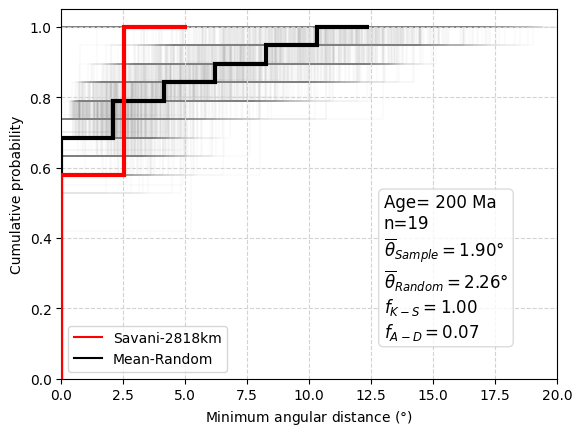

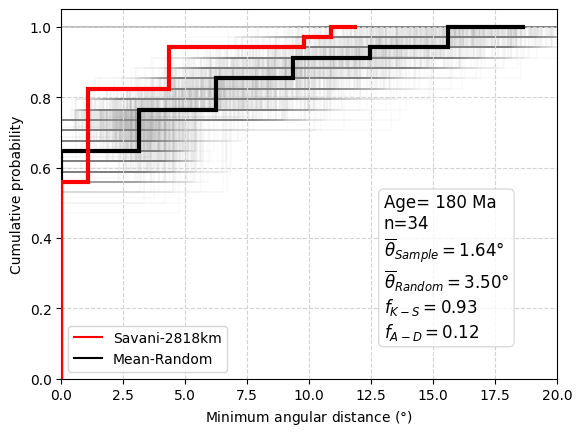

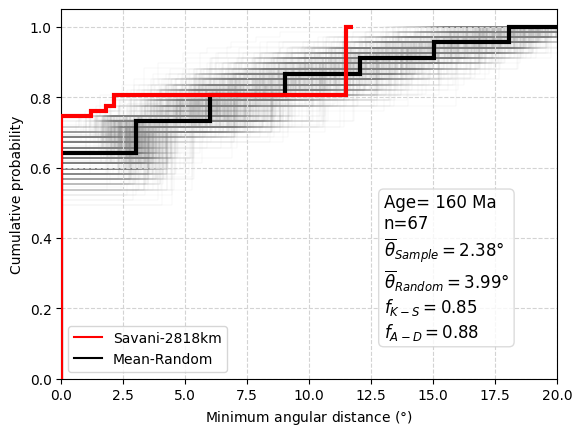

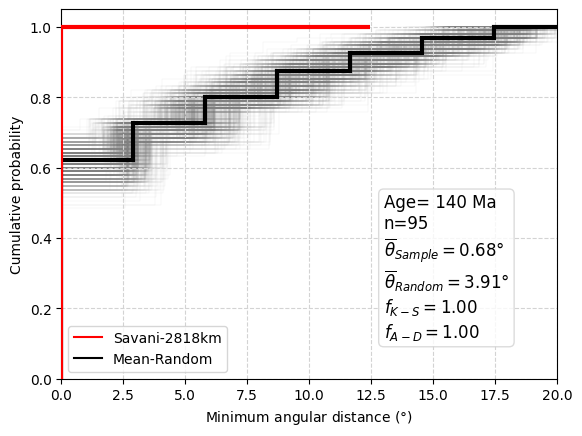

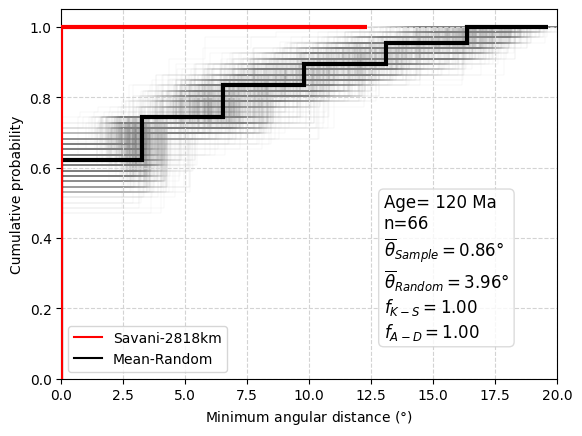

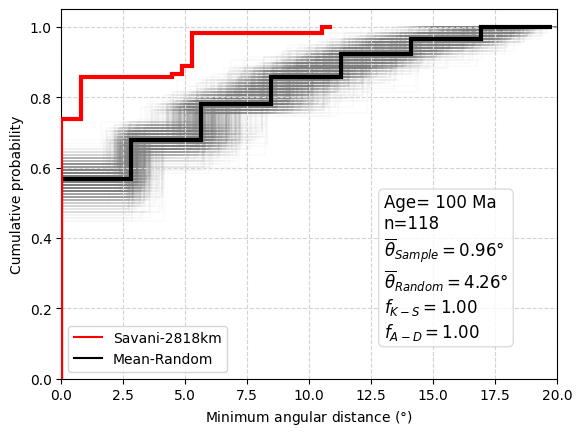

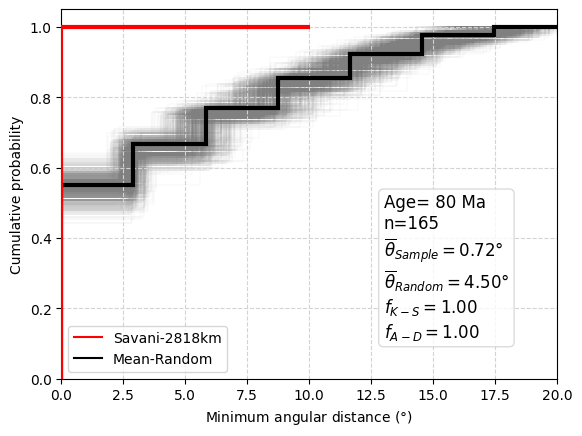

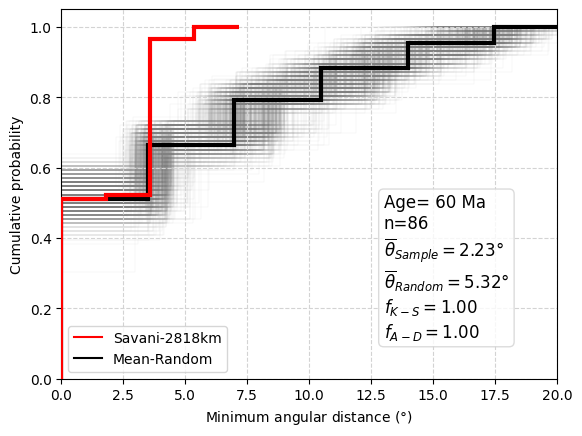

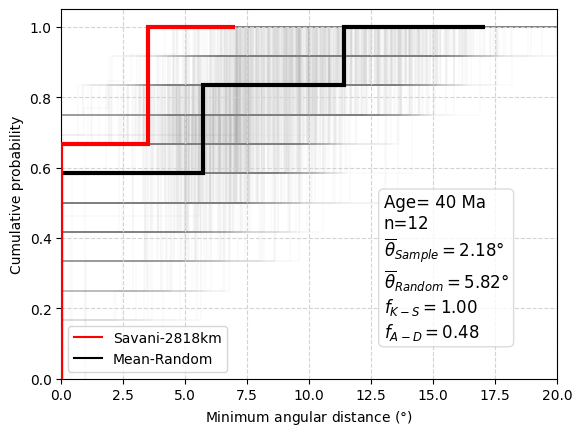

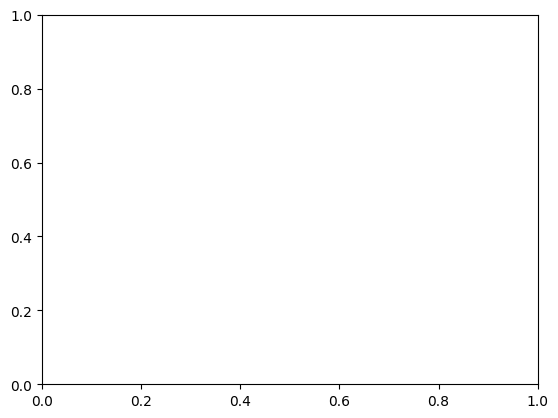

In [18]:
# root_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# grid_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# solid_plot_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/solid'
KimberlitesFile='/Users/omer/Desktop/NatGeoReviews/Kimberlites/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'
pc = pygplates.FeatureCollection(KimberlitesFile)
window = 10
# Tmin = int(160)
# Tmax = int(320)
# Tmax = int(180)

CalcOutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km/"
grid_dir="/Users/omer/Desktop/NatGeoReviews/Tomographic-Models/Savani/"
OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km/"
TomogModelN="Savani_2818"


# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)   


recon_label = 'M21'
ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21/'
cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
cratons = pygplates.FeatureCollection(cratonFile)    

input_rotation_filename = '%s/1000_0_rotfile_Merdith_et_al.rot' % ReconstructionDir
ANCHOR_ID = int(0)

rotation_model=pygplates.RotationModel(input_rotation_filename)



# fig2, ax2 = plt.subplots()
nTests=1000

for Age in np.arange(200,0,-20):
    fig, ax = plt.subplots()
    age = int(Age)
    print(Age, 'Ma')
    agemax = age+window
    agemin = age-window

    point_lats = []
    point_lons = []
    
    MIN_DISTANCE_HOT_DEG=[]
    MIN_SOLID_DISTANCE_DEG = []
    MIN_DISTANCE_HOT_DEG = []
    MIN_DISTANCE_HOT_DEG_STD = []

#     DistancetoHot="%s/%s_Distance_to_Hot.nc" %(CalcOutputDir,TomogModelN)
    DistancetoHot="%s/%s_Distance_to_Hot_%s_AreaVaried.nc" %(CalcOutputDir,TomogModelN,str(age))
    print(DistancetoHot)
    point_lons, point_lats = get_volcanic_product_long_lat(rotation_model,ANCHOR_ID,age,window,pc)

    pdist2hot = sample_using_gmt(DistancetoHot, point_lons, point_lats,CalcOutputDir)
    
    if len(pdist2hot) > 0:

#         CUMULATIVE_MIN_DISTANCE_HOT_DEG.extend(pdist2hot)
        MIN_DISTANCE_HOT_DEG=pdist2hot
        MIN_DISTANCE_HOT_DEG_STD=np.std(pdist2hot)
        
#     print(CUMULATIVE_MIN_DISTANCE_HOT_DEG_STD)
    
    MEAN_MIN_SOLID_DISTANCE_DEG = []
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = []

    
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = np.median(np.array(MIN_DISTANCE_HOT_DEG),axis=0)


    MEAN_MIN_SOLID_DISTANCE_DEG = np.mean(np.array(MIN_DISTANCE_HOT_DEG),axis=0)
    print(MEAN_MIN_SOLID_DISTANCE_DEG,'is the mean of the sample')
    
    # Calculate how many points are on Hot Structures -->
    k=np.asarray(MIN_DISTANCE_HOT_DEG)
    k=np.where(k<0.01,0.0,k)
    # np.where(np.asarray(CUMULATIVE_MIN_SOLID_DISTANCE_DEG) < 0.5)
    NumberOfPointsOnCold=np.count_nonzero(np.asarray(k))
    FractionOfPointsOnHotSOLIDCASE=100.0*(float(len(MIN_DISTANCE_HOT_DEG))-NumberOfPointsOnCold)/float(len(MIN_DISTANCE_HOT_DEG))
    print(FractionOfPointsOnHotSOLIDCASE,'% of the points are on Hot Structures')
    # --->
    
    
    
    #work out the random test
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG = []

    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    STD_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED =[]
    
    ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEDIANS_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEANS_ALL_RANDOM_SAMPLES_SOLID = []
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf=[]
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc=[]
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID=[]
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID=[]
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID=[]
    FRACTION_MEANS_AD_ALL_MODELS_SOLID=[]
    MEAN_MEDIANS_ALL_MODELS_SOLID=[]
    MEDIAN_ALL_MODELS_SOLID=[]
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID=[]
    CumulativeRand=[]

    numKimbs=int(len(MIN_DISTANCE_HOT_DEG))
    print(numKimbs)
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided=[]
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided=[]
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided=[]
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided=[]
    for m in range(nTests):
        
        if m % 10 == 0:
            print('Random', m+1, 'out of', nTests)
        
        MIN_RANDOM_DISTANCE_TO_HOT = []
        MIN_RANDOM_DISTANCE_TO_HOT_DEG = []
        MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
        
        random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
        
        if len(random_pdist2hot) > 0:

            MIN_RANDOM_DISTANCE_TO_HOT.extend(random_pdist2hot)

        MIN_RANDOM_SOLID_DISTANCE_DEG = MIN_RANDOM_DISTANCE_TO_HOT
        
        
        if(len(MIN_DISTANCE_HOT_DEG)==len(random_pdist2hot)):
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG.append(MIN_RANDOM_DISTANCE_TO_HOT)        
        else:
            print('MUTATION!')
#             random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
    
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG=ALL_MIN_RANDOM_SOLID_DISTANCE_DEG

        MEANS_ALL_RANDOM_SAMPLES_SOLID.append(np.mean(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
       
        MEDIANS_ALL_RANDOM_SAMPLES_SOLID.append(np.median(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
 
        #plot the cumulative histogram
        n, bins, patches = ax.hist(MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                                cumulative=True, color='grey', linewidth=0.2, zorder=1,alpha=0.20)

        patches[0].set_xy(patches[0].get_xy()[:-1])
        
        
       
        AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG, 
                                                 MIN_RANDOM_SOLID_DISTANCE_DEG])
        
        
        ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID.append(AD1S)
        ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID.append(AD3S)
#         print(AD3S, "... confidence level")
        ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID.append(AD2S[2])
    
        KS1tS, KS2tS = stats.ks_2samp(MIN_DISTANCE_HOT_DEG, MIN_RANDOM_SOLID_DISTANCE_DEG,
                                      alternative='two-sided', mode='exact')

        KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided.append(KS1tS)
        KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided.append(KS2tS)
        
    #work out the fraction of random tests for which the null hypothesis cannot be rejected,
    #i.e. the sample distribution significantly differs from the random distribution
    ADFS_conf=float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
    ADFS_conf_0_25=float(sum(i < 0.25 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    print(ADFS_conf,ADFS_conf_0_25, " are ADFS_conf and ADFS_conf_0_25")

    count_ADS=0
    for k in range(len(ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID)):
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[k]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[k]:
            count_ADS+=1
    
    ADFS_5pc=float(float(count_ADS)/float(len(ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID)))
        

    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc=[]
    
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf.append(ADFS_conf)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc.append(ADFS_5pc)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc.append(ADFS_conf_0_25)
    

    p=0.05
    
    n=int(len(MIN_DISTANCE_HOT_DEG))
    
    if(n==19):
        KScritNEW=0.1280
        print("n=19")
    elif(n==12):
        KScritNEW=0.1287
        print("n=12")
    else:
        KScritNEW=math.sqrt(-1.0*(math.log(1-p))/2.0) -(1.0/6.0)*n**(-1.0/2.0) +1/n
        print("n>30")
   
    KSFS_stat_two_sided=float(sum(i > KScritNEW for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))

    KSFS_pval_two_sided=float(sum(i < 0.05 for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))
    
    countSmean_KS=0
    for l in range(nTests):
        
        #find the number of successful tests for the solid case
#         if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
#         or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
#             countSmean_KS+=1
        
        if (KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW):
            countSmean_KS+=1
        
    FRACTION_KS_Crit=float(1.0- countSmean_KS/nTests)
    
    countSmean_KS=0
    for l in range(nTests):
        
        if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
        or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
            countSmean_KS+=1
     
    FRACTION_KS_Crit_TwoCond=float(1.0- countSmean_KS/nTests)        
    
   #
#     ADFS_conf=float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
#     count_ADS=0
#     for k in range(len(ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID)):
#         if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[k]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[k]:
#             count_ADS+=1
    
#     ADFS_5pc=float(float(count_ADS)/float(len(ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID)))
    
#     FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf.append(ADFS_conf)
#     FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc.append(ADFS_5pc)
    
    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided.append(KSFS_stat_two_sided)
    
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided.append(KSFS_pval_two_sided)


    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_SMALLER_MEDIANS_SOLID=float(sum(abs(i) > abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) for i in MEDIANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEDIANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEDIANS_SOLID)
   
    FRACTION_SMALLER_MEANS_SOLID = float(sum(i > MEAN_MIN_SOLID_DISTANCE_DEG for i in MEANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEANS_SOLID)
    
    
    countSmean=0 # 
#     countEmean=0
    countSmedian=0
    countSmeanWeak=0
#     countEmedian=0
    for l in range(nTests):
        if MEANS_ALL_RANDOM_SAMPLES_SOLID[l] >= MEAN_MIN_SOLID_DISTANCE_DEG \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmean+=1
            
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmeanWeak+=1    
                
        if abs(MEDIANS_ALL_RANDOM_SAMPLES_SOLID[l]) >= abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmedian+=1
            
    FRACTION_MEANS_AD_SOLID=float(float(countSmean)/float(nTests))
    FRACTION_MEANS_AD_SOLIDWeak=float(float(countSmeanWeak)/float(nTests))
    FRACTION_MEANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEANS_AD_SOLID)

    FRACTION_MEDIANS_AD_SOLID=float(float(countSmedian)/float(nTests))
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEDIANS_AD_SOLID)
    
#     print((100.0*float(countSmean)/nTests),' % of the time mean of the sample is less than random-Solid and Significantly Differs From Random')
    
    MEAN_MEDIANS_ALL_MODELS_SOLID.append(np.mean(np.array(MEDIANS_ALL_RANDOM_SAMPLES_SOLID),axis=0))
    
    #work out mean and median for the average of random samples for the solid case
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED=np.sort(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG, axis=-1,kind='stable')
    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED),axis=0)

#     below are the actual mim-max range
    MIN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amin(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    MAX_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amax(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.median(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
            
    MEDIAN_ALL_MODELS_SOLID.append(MEDIAN_MIN_SOLID_DISTANCE_DEG)
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID.append(MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG)
    
    
    
    n6, bins6, patches6 = ax.hist(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                            cumulative=True, label='Mean-Random', color='black', linewidth=3, zorder=4)
    
    patches6[0].set_xy(patches6[0].get_xy()[:-1])

    
    #plot the cumulative histogram
#     a=np.asarray(MIN_SOLID_DISTANCE_DEG)
    a=np.asarray(MIN_DISTANCE_HOT_DEG)
    a=a.round(4)
    
    n7, bins7, patches7 = ax.hist(a, bins='fd', density=True, histtype='step',
                            cumulative=True, label='Savani-2818km', color='red', linewidth=3, zorder=5)
        
    patches7[0].set_xy(patches7[0].get_xy()[:-1])
    
    # tidy up the figure

    #ax.grid(True)
#     ax.grid()
    ax.grid(zorder=0,linestyle='--', color='lightgrey')
#     ax.legend(loc='lower right')
    ax.set_xlim(0,20)
    #ax.set_title('Cumulative step histograms')
    ax.set_xlabel('Minimum angular distance ($\degree$)')
    ax.set_ylabel('Cumulative probability')
#     ax.set_title('{:s} (Solid)'.format(model_case))

    textstr = '\n'.join((
        r'Age= %i Ma' %(Age,),
        r'n=%i' %(numKimbs,),
        r'$\overline{\theta}_{Sample}=%.2f\degree$' % (MEAN_MIN_SOLID_DISTANCE_DEG, ),
        r'$\overline{\theta}_{Random}=%.2f\degree$' %(np.mean(MEANS_ALL_RANDOM_SAMPLES_SOLID), ),
        r'$f_{K-S}=%.2f$' %(FRACTION_KS_Crit), # based on critical val.
        r'$f_{A-D}=%.2f$' %(ADFS_conf))) # 5 percent sig.


#         r'${\kappa}_{\bar{\theta}}=%.2f$' % (FRACTION_SMALLER_MEANS_SOLID, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.80,edgecolor='lightgrey')
    #ax.grid(True)
#     ax.grid(zorder=0,linestyle='--', color='lightgrey')
    # Create new legend handles but use the colors from the existing ones
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=new_handles[::-1], labels=labels[::-1], loc='lower left')
    ax.text(0.65, 0.10, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)
 
    ax.grid(zorder=1,linestyle='--', color='lightgrey')
    
    fig.savefig('/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/2818km/Savani-2818-km-'+str(Age)+'-Ma_AreaVaried.pdf', 
                bbox_inches='tight', dpi=600)
    
#     plt.show()
    
    OutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/Savani/Saved-Arrays"
    
    np.savetxt(OutputDir+'/Savani-2818km-MIN-DISTANCES_'+str(Age)+'_Ma_AreaVaried.txt',MIN_DISTANCE_HOT_DEG)

    np.save(OutputDir+'/Savani-2818km-MIN-DISTANCES-STD_'+str(Age)+'_Ma_AreaVaried.npy',MIN_DISTANCE_HOT_DEG_STD)

    np.save(OutputDir+'/Savani-2818km-AD-Test-conf-5p-'+str(Age)+'_Ma_AreaVaried.npy',ADFS_conf)

    np.save(OutputDir+'/Savani-2818km-AD-Test-conf-25p-'+str(Age)+'_Ma_AreaVaried.npy',ADFS_conf_0_25)

    np.save(OutputDir+'/Savani-2818km-ks-stat-two-sided-'+str(Age)+'_Ma_AreaVaried.npy',KSFS_stat_two_sided)
    
    np.save(OutputDir+'/Savani-2818km-ks-stat-pval-'+str(Age)+'_Ma_AreaVaried.npy',KSFS_pval_two_sided)
   
    np.save(OutputDir+'/Savani-2818km-ks-stat-TwoCond-'+str(Age)+'_Ma_AreaVaried.npy',FRACTION_KS_Crit_TwoCond)
    
    np.save(OutputDir+'/Savani-2818km-KS-Stat-critical-val'+str(Age)+'_Ma_AreaVaried.npy',FRACTION_KS_Crit)






In [ ]:
# len(MIN_DISTANCE_HOT_DEG),len(random_pdist2hot)
#             ALL_MIN_RANDOM_SOLID_DISTANCE_DEG.append(MIN_RANDOM_DISTANCE_TO_HOT) 

In [ ]:
# random_pdist2hot

In [ ]:
# FRACTION_MEANS_AD_SOLID is the % that shorter distance and highly difference from random is achieved.

In [ ]:
# FRACTION_MEANS_AD_SOLID,FRACTION_MEANS_AD_SOLIDWeak